<left><img src="https://i.ibb.co/zWjkHsWJ/marca-final-rgb-campanha-2025-versao02.png" width="35%" height="35%"></left>

# Tópicos em Matemática Aplicada: Deep Learning (Aula 07)

**Exemplo 1: ResNet**

Data: 23/set/25


---

# Redes Residuais (ResNet)

Neste notebook, vamos explorar a arquitetura de Redes Neurais Residuais (ResNets), proposta no artigo "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" por Kaiming He et al.

## O Problema: A Degradação de Redes Profundas

Intuitivamente, poderíamos pensar que quanto mais camadas uma rede neural tem, melhor deveria ser seu desempenho. No entanto, na prática, os pesquisadores observaram um fenômeno chamado **problema de degradação**: à medida que a rede fica mais profunda, a precisão de treinamento satura e depois começa a degradar rapidamente. Isto quer dizer que uma rede muito profunda tem dificuldade em aprender uma **função identidade**. Imagine que uma camada adicional não é necessária. O ideal seria que essa camada simplesmente passasse a entrada adiante sem alterá-la. No entanto, é muito difícil para as camadas aprenderem a fazer exatamente isso.

Neste caso, os gradientes podem desaparecer (*vanishing gradients*) ou explodir (*exploding gradients*), tornando o treinamento ineficaz.


## A Solução: Blocos Residuais e "Skip Connections"

A ideia central da ResNet é introduzir "conexões de atalho" ou **"skip connections"**. Em vez de forçar as camadas a aprenderem uma transformação completa do zero (mapeamento $f(\mathbf{x})$, a ResNet as treina para aprender uma função residual $g(\mathbf{x})$.

O mapeamento final se torna: $f(\mathbf{x})=g(\mathbf{x})+\mathbf{x}$

- $\mathbf{x}$: A entrada do bloco (a identidade, passada pela *skip connection*).
- $g(\mathbf{x})$: A transformação aprendida pelas camadas dentro do bloco.

A intuição é que é muito mais fácil para a rede aprender a "não fazer nada" (ou seja, fazer $g(\mathbf{x})$ ser próximo de zero) do que aprender uma transformação de identidade. Isso permite que a rede adicione camadas que, no pior caso, não prejudicam o desempenho, facilitando o treinamento de modelos extremamente profundos.

![Diagrama dos Blocos Residuais](https://d2l.ai/_images/residual-block.svg)

Figura: Em um bloco regular (esquerda), a parte dentro da caixa pontilhada precisa aprender diretamente o mapeamento $f(\mathbf{x})$. Em um bloco residual (direita), a parte dentro da caixa pontilhada precisa aprender o mapeamento residual $g(\mathbf{x})=f(\mathbf{x})-\mathbf{x}$, tornando o mapeamento da identidade $f(\mathbf{x})=\mathbf{x}$ mais fácil de aprender.


## Arquitetura ResNet-20 para CIFAR-10

![](https://www.researchgate.net/publication/376967396/figure/fig4/AS:11431281215018239@1703941935933/Partial-structure-diagram-of-Resnet20.ppm)

A ResNet-20 é uma variante menor, projetada especificamente para conjuntos de dados como o CIFAR-10. Sua estrutura é:

1.  Uma camada convolucional inicial.
2.  **3 estágios** de blocos residuais. Cada estágio tem 3 blocos (total de 9 blocos).
    - Estágio 1: 16 filtros.
    - Estágio 2: 32 filtros (com *downsampling* no início).
    - Estágio 3: 64 filtros (com *downsampling* no início).
3.  Uma camada de *Average Pooling* Global.
4.  Uma camada totalmente conectada (linear) para a classificação final.

Considerando que cada `BasicBlock` tem 2 camadas convolucionais, a conta é:
1 (conv1) + (3 + 3 + 3) blocos * 2 (camadas/bloco) + 1 (linear) = 1 + 18 + 1 = 20 camadas, por isso ResNet-20.

Vamos implementar isso passo a passo!

In [ ]:
# Importa as bibliotecas necessárias do PyTorch e Torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# --- Seleção de Dispositivo ---
# Verificamos a disponibilidade de diferentes aceleradores de hardware
# na seguinte ordem de prioridade: CUDA (NVIDIA) -> MPS (Apple Silicon) -> CPU.
if torch.cuda.is_available():
    # Verifica se há uma GPU da NVIDIA disponível
    device = 'cuda'
elif torch.backends.mps.is_available():
    # Verifica se o backend MPS está disponível (para Macs com Apple Silicon, meu caso)
    device = 'mps'
else:
    # Caso contrário, usa a CPU como fallback
    device = 'cpu'

# Imprime o dispositivo que será utilizado para o treinamento
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


## Passo 1: Construindo o Bloco Residual Básico

Este é o coração da ResNet. O `BasicBlock` contém duas camadas convolucionais. A "mágica" acontece na função `forward`, onde somamos a saída do bloco (`out`) com a entrada original (`x`), que foi passada pela `shortcut`.

Note que, se as dimensões mudam (por exemplo, quando o `stride` é 2 para fazer *downsampling* ou quando o número de canais aumenta), a `shortcut` também precisa transformar `x` para que a soma seja possível. Isso é feito com uma convolução 1x1.

In [ ]:
# Definição do Bloco Residual Básico (BasicBlock)

class BasicBlock(nn.Module):
    # Fator de expansão para o número de canais (para ResNets mais profundas)
    # No nosso caso (ResNet20), é sempre 1.
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # Primeira camada convolucional do bloco
        # O stride pode ser > 1 para realizar o downsampling espacial
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # Normalização em lote

        # Segunda camada convolucional do bloco
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # Normalização em lote

        # A "skip connection"
        self.shortcut = nn.Sequential() # Começa como uma identidade

        # Se o stride não for 1 ou o número de canais de entrada/saída for diferente,
        # precisamos ajustar a dimensão da identidade 'x' para que ela possa ser somada
        # à saída do bloco. Isso é feito com uma convolução 1x1 com o stride adequado.
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        # Passagem pela primeira camada conv, batch norm e ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        # Passagem pela segunda camada conv e batch norm
        out = self.bn2(self.conv2(out))
        # A SOMA MÁGICA: saída do bloco + atalho (identidade transformada)
        out += self.shortcut(x)
        # Aplica a função de ativação ReLU APÓS a soma
        out = F.relu(out)
        return out

## Passo 2: Montando a Arquitetura ResNet Completa

Agora, usamos o `BasicBlock` para construir a rede inteira. A classe `ResNet` é genérica e pode criar diferentes tamanhos de ResNet (como ResNet-18, 34, etc.) dependendo dos parâmetros.

- `_make_layer`: Uma função auxiliar para criar um estágio da rede, empilhando vários `BasicBlock` em sequência.
- `ResNet20()`: Uma função que instancia a classe `ResNet` com a configuração específica da ResNet-20 para CIFAR-10 (`[3, 3, 3]` blocos por estágio).

In [ ]:
# 3. Definição da Arquitetura ResNet Completa

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16 # Número de canais de entrada para o primeiro estágio

        # Camada convolucional inicial (antes dos blocos residuais)
        # Para CIFAR-10, usamos um kernel 3x3 com stride 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Estágios de blocos residuais
        # O primeiro estágio tem 16 canais de saída
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        # O segundo estágio tem 32 canais e faz downsampling (stride=2)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        # O terceiro estágio tem 64 canais e faz downsampling (stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Camada de Average Pooling Global para reduzir a dimensão espacial a 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Camada linear final para classificação (10 classes para CIFAR-10)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # Define os strides para os blocos dentro de um estágio
        # O primeiro bloco pode ter stride > 1 (para downsampling), os demais terão stride 1
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Passagem pela camada inicial
        out = F.relu(self.bn1(self.conv1(x)))
        # Passagem pelos estágios de blocos residuais
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Passagem pelo average pooling
        out = self.avgpool(out)
        # "Achata" o tensor para a camada linear
        out = torch.flatten(out, 1)
        # Passagem pela camada linear de classificação
        out = self.linear(out)
        return out

# Função para criar o modelo ResNet-20
# A lista [3, 3, 3] significa 3 blocos no estágio 1, 3 no estágio 2 e 3 no estágio 3.
# Total de blocos = 9. Cada bloco tem 2 camadas conv -> 9*2=18 camadas.
# +1 camada conv inicial +1 camada linear = 20 camadas.
def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3], num_classes=10)

# Vamos testar se o modelo é criado corretamente e movê-lo para o dispositivo
model = ResNet20().to(device)
print(model)

# Teste rápido com um tensor aleatório para ver se as dimensões estão corretas
dummy_input = torch.randn(1, 3, 32, 32).to(device)
output = model(dummy_input)
print("\nDimensão da saída do modelo:", output.shape)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

## Passo 3: Preparando os Dados (CIFAR-10)

Agora, vamos carregar e pré-processar o conjunto de dados CIFAR-10. Aplicaremos algumas transformações para aumentar a variedade dos dados de treino (*data augmentation*), como recortes e espelhamentos aleatórios, além da normalização.

In [ ]:
# 4. Carregamento e Preparação dos Dados (CIFAR-10)

# Importa a biblioteca para lidar com diretórios temporários (foi necessário para rodar localmente no Mac)
import tempfile
from pathlib import Path

# Cria um diretório temporário seguro para baixar nossos dados
# Isso garante que teremos permissão de escrita, independentemente do ambiente.
data_dir = tempfile.mkdtemp()
print(f"Dados do CIFAR-10 serão baixados em: {data_dir}")


# Definindo as transformações para os dados
# Para o treino, adicionamos data augmentation para melhorar a generalização
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Recorte aleatório
    transforms.RandomHorizontalFlip(),         # Espelhamento horizontal aleatório
    transforms.ToTensor(),                     # Converte a imagem para Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    ])

# Para o teste, apenas convertemos para Tensor e normalizamos
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

# Baixando os datasets de treino e teste, usando o diretório temporário que criamos
trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform_test)

# Criando os DataLoaders para carregar os dados em lotes
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Nomes das classes para referência
classes = ('avião', 'carro', 'pássaro', 'gato', 'veado',
           'cachorro', 'sapo', 'cavalo', 'barco', 'caminhão')

Dados do CIFAR-10 serão baixados em: /tmp/tmp77uupomv


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


## Passo 4: Treinando o Modelo

Finalmente, vamos definir a função de perda (loss), o otimizador e o loop de treinamento.

- **Função de Perda**: Usaremos `CrossEntropyLoss`, que é padrão para problemas de classificação multi-classe.
- **Otimizador**: `Adam` é uma escolha robusta e popular que geralmente funciona bem com pouca necessidade de ajuste de hiperparâmetros.
- **Loop de Treinamento**: Para cada época, iteramos sobre os dados de treino, calculamos a perda, fazemos a retropropagação (*backpropagation*) e atualizamos os pesos. Ao final de cada época, avaliamos o modelo no conjunto de teste para monitorar a precisão.

In [ ]:
# 5. Configuração do Treinamento e Loop de Treino/Validação

# Recriamos o modelo para garantir que ele comece do zero
model = ResNet20().to(device)

# Definindo a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Número de épocas para treinar
num_epochs = 30 # Sinta-se à vontade para aumentar para melhores resultados

# ----- Função de Treinamento -----
def train(epoch):
    print(f'\nÉpoca: {epoch+1}')
    model.train() # Coloca o modelo em modo de treinamento
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad() # Zera os gradientes
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Calcula a perda
        loss.backward() # Backward pass (calcula os gradientes)
        optimizer.step() # Atualiza os pesos

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Imprime o progresso
        if (batch_idx + 1) % 100 == 0:
            print(f'Lote [{batch_idx+1}/{len(trainloader)}] | Perda: {train_loss/(batch_idx+1):.3f} | Precisão: {100.*correct/total:.3f}% ({correct}/{total})')

# ----- Função de Validação/Teste -----
def test(epoch):
    model.eval() # Coloca o modelo em modo de avaliação
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # Desativa o cálculo de gradientes para economizar memória
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Imprime a precisão no final da época
    acc = 100.*correct/total
    print(f'*** Validação Final da Época {epoch+1} ***')
    print(f'Perda no Teste: {test_loss/len(testloader):.3f} | Precisão no Teste: {acc:.3f}% ({correct}/{total})')
    print('--------------------------------------------------')

# ----- Loop Principal -----
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)

print('Treinamento concluído!')


Época: 1
Lote [100/391] | Perda: 1.800 | Precisão: 32.789% (4197/12800)
Lote [200/391] | Perda: 1.654 | Precisão: 38.441% (9841/25600)
Lote [300/391] | Perda: 1.554 | Precisão: 42.469% (16308/38400)
*** Validação Final da Época 1 ***
Perda no Teste: 1.249 | Precisão no Teste: 54.640% (5464/10000)
--------------------------------------------------

Época: 2
Lote [100/391] | Perda: 1.161 | Precisão: 58.266% (7458/12800)
Lote [200/391] | Perda: 1.144 | Precisão: 59.016% (15108/25600)
Lote [300/391] | Perda: 1.118 | Precisão: 59.922% (23010/38400)
*** Validação Final da Época 2 ***
Perda no Teste: 1.042 | Precisão no Teste: 62.860% (6286/10000)
--------------------------------------------------

Época: 3
Lote [100/391] | Perda: 0.977 | Precisão: 65.203% (8346/12800)
Lote [200/391] | Perda: 0.948 | Precisão: 66.289% (16970/25600)
Lote [300/391] | Perda: 0.931 | Precisão: 66.784% (25645/38400)
*** Validação Final da Época 3 ***
Perda no Teste: 0.898 | Precisão no Teste: 68.480% (6848/10000)

## Passo 5: Avaliando o Desempenho do Modelo

Vamos dar uma olhada na matriz de confusão:

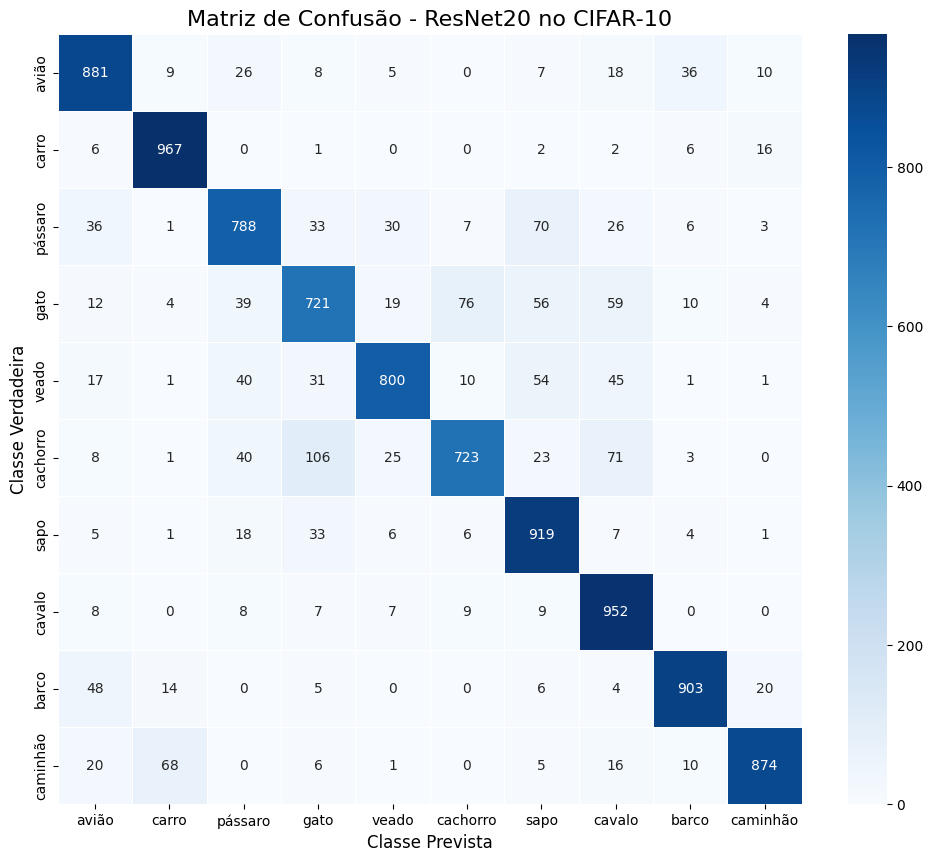

In [ ]:
# 6. Análise de Resultados: Matriz de Confusão

# Importando bibliotecas necessárias para a visualização
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Listas para armazenar todas as previsões e rótulos verdadeiros
all_preds = []
all_labels = []

# Coloca o modelo em modo de avaliação
model.eval()

# Desativa o cálculo de gradientes para acelerar a inferência
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Obtém as saídas do modelo
        outputs = model(inputs)
        # Obtém a classe com a maior probabilidade (a previsão)
        _, predicted = torch.max(outputs.data, 1)

        # Adiciona as previsões e os rótulos do lote atual às listas gerais
        # .cpu() é necessário para mover os tensores para a CPU antes de convertê-los para numpy
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula a matriz de confusão usando o scikit-learn
cm = confusion_matrix(all_labels, all_preds)

# Cria um DataFrame do Pandas para facilitar a plotagem com rótulos
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

# Plota a matriz de confusão usando o Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Matriz de Confusão - ResNet20 no CIFAR-10', fontsize=16)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.xlabel('Classe Prevista', fontsize=12)
plt.show()

### Análise Visual de Previsões

Além da matriz, é muito útil olhar para exemplos concretos. Vamos pegar algumas imagens do conjunto de teste e ver o que o modelo previu para elas.

Isso nos dá uma intuição qualitativa de onde o modelo acerta e onde ele erra. Colorimos os resultados:

-   **Verde**: A previsão está correta.
-   **Vermelho**: A previsão está incorreta.

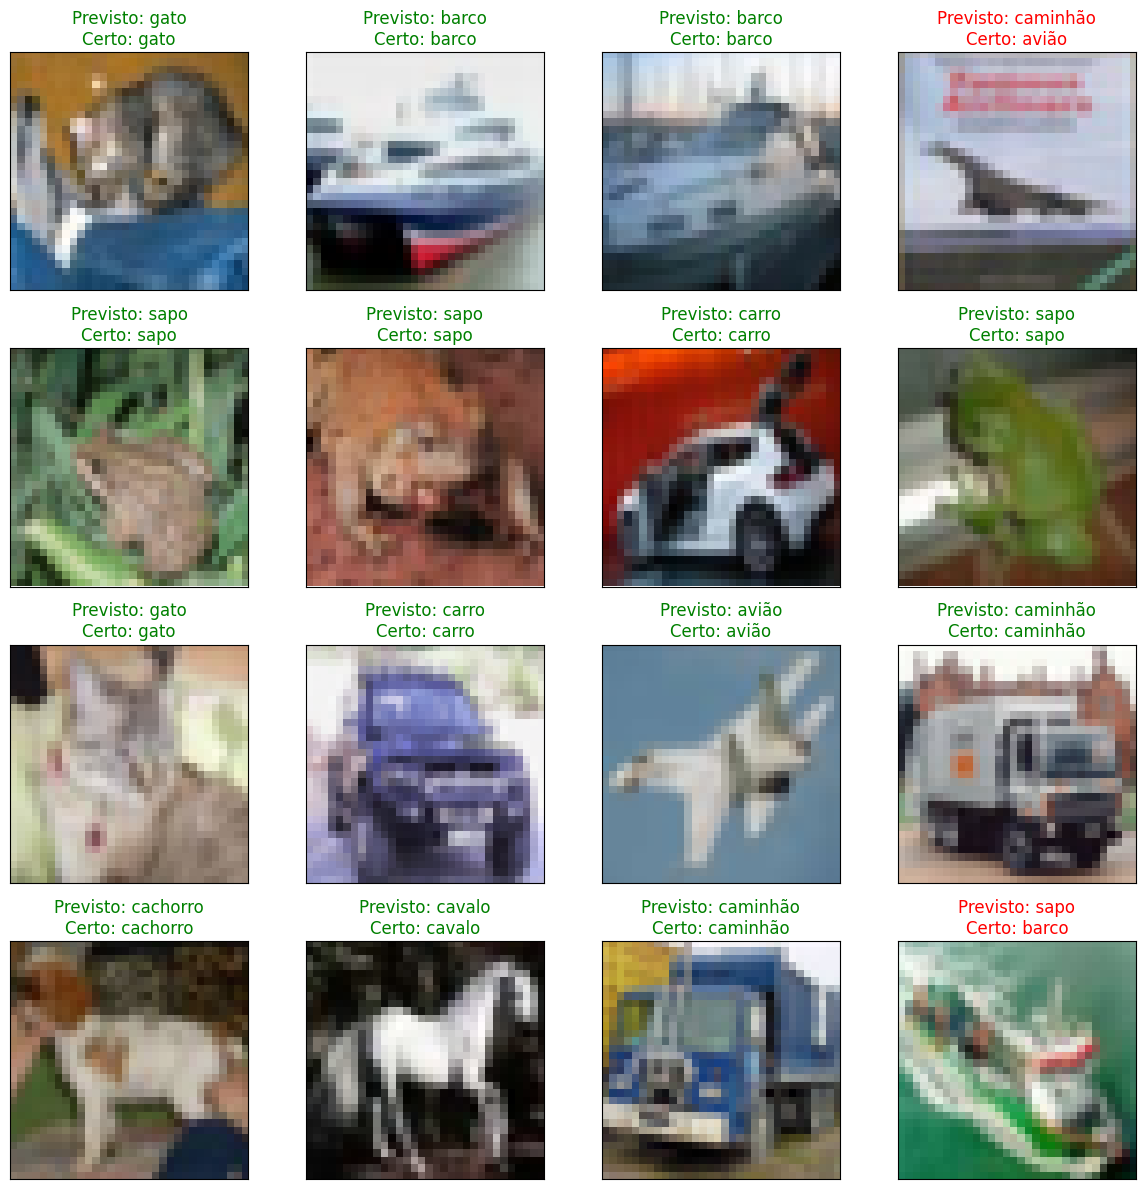

In [ ]:
# 7. Análise de Resultados: Visualização de Previsões

# Função auxiliar para desnormalizar e mostrar uma imagem
def imshow(img):
    # As imagens foram normalizadas. Precisamos reverter o processo para visualizá-las.
    # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    npimg = img.numpy()
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Pega um lote de imagens do conjunto de teste
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move as imagens para o dispositivo (GPU/MPS) para fazer a previsão
images_for_prediction = images.to(device)

# Coloca o modelo em modo de avaliação e faz as previsões
model.eval()
with torch.no_grad():
    outputs = model(images_for_prediction)
    _, predicted = torch.max(outputs, 1)

# Move as previsões de volta para a CPU para podermos usá-las com numpy/matplotlib
predicted = predicted.cpu()

# Mostra as imagens em uma grade 4x4
fig = plt.figure(figsize=(12, 12))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    # Desnormaliza e mostra a imagem
    imshow(images[idx])

    # Define a cor do título com base se a previsão foi correta
    true_label = classes[labels[idx].item()]
    pred_label = classes[predicted[idx].item()]
    color = "green" if true_label == pred_label else "red"

    # Define o título da imagem
    ax.set_title(f"Previsto: {pred_label}\nCerto: {true_label}", color=color)

plt.tight_layout()
plt.show()

## Conclusão

**Principais pontos:**
1.  **O Problema da Degradação:** Redes mais profundas não são necessariamente melhores se não forem projetadas corretamente.
2.  **Blocos Residuais:** A "skip connection" ($f(\mathbf{x})=g(\mathbf{x})+\mathbf{x}$) é a chave para permitir que o gradiente flua mais facilmente e para treinar redes muito mais profundas.
3.  **Implementação Prática:** Vimos como construir o bloco, empilhá-lo para formar a rede completa e treinar o modelo em um conjunto de dados padrão como o CIFAR-10.

A partir daqui, você pode experimentar com arquiteturas mais profundas (como ResNet-34, 56) ou aplicar essa mesma ideia a outros problemas!